In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from statsmodels.stats.multitest import multipletests

## Preprocess anndata

In [2]:
# Load the AnnData labeling with cell cycle annotations
adata = ad.read_h5ad("/home/jiguo/data/data/anndata/adata_all_pp_cc.h5") 
adata

AnnData object with n_obs × n_vars = 12572 × 11428
    obs: 'condition', 'replicate', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_genes', 'S_score', 'G2M_score', 'phase'
    var: 'ensembl_gene_id', 'gene_name', 'in_jakobsen', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'log1p'
    layers: 'counts', 'log', 'normalised', 'regress_cc'

### Load the Gene list A (All genes related to RNA metabolism)

In [3]:
# Select the genes of interest
gene_list = pd.read_csv("/home/jiguo/denovo_rpe1_scrnaseq/Genes_with_GO_terms_RNA-metabolic-process - select.csv")["Gene names"].tolist()
# gene_list = [gene.upper() for gene in gene_list] 
gene_mask = adata.var['gene_name'].isin(gene_list)
A_adata = adata[:, gene_mask].copy()
A_adata

AnnData object with n_obs × n_vars = 12572 × 1238
    obs: 'condition', 'replicate', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_genes', 'S_score', 'G2M_score', 'phase'
    var: 'ensembl_gene_id', 'gene_name', 'in_jakobsen', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'log1p'
    layers: 'counts', 'log', 'normalised', 'regress_cc'

In [4]:
def calculate_gene_expression(adata, gene_list):
    total_expression = adata[:, adata.var['gene_name'].isin(gene_list)].X.sum(axis=1)
    # Ensure total_expression is a numpy array
    return total_expression
total_expression = calculate_gene_expression(adata, gene_list)
# plot different total gene expression level in the UMAP
def plot_gene_expression(adata, total_expression):
    adata.obs['total_expression'] = total_expression
    rcParams['figure.figsize'] = (20, 10)
    fig_ind = np.arange(231, 237)
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.6)
    p11 = sc.pl.umap(adata, color='total_expression', cmap='viridis', vmin=0, vmax=np.percentile(total_expression, 95), 
               title='Total Gene Expression', ax=fig.add_subplot(fig_ind[2]), show=False, )
    p12 = sc.pl.umap(adata, color='condition', ax=fig.add_subplot(fig_ind[1]), show=False)
    # make a violin plot of total expression
    
    plt.show()

In [5]:
# calculate log counts AFTER filtering
adata.obs['log_n_counts'] = np.log(adata.obs['total_counts'])


### Calculate UMAP based on the Genes in the List A

In [6]:
A_adata.X = A_adata.layers['normalised'].copy()
n_neighbors=15
min_dist=0.5
n_components=2
sc.pp.pca(A_adata, n_comps=50, use_highly_variable=False, svd_solver='arpack')
sc.pp.neighbors(A_adata, n_neighbors=n_neighbors, n_pcs=40)
sc.tl.umap(A_adata,min_dist=min_dist, n_components=n_components)

/home/jiguo/denovo_rpe1_scrnaseq/venvs/rna/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


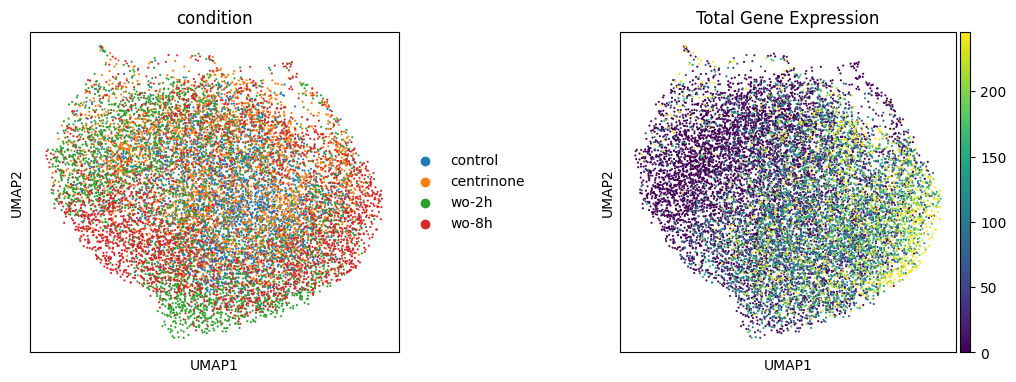

In [7]:
plot_gene_expression(A_adata, total_expression)

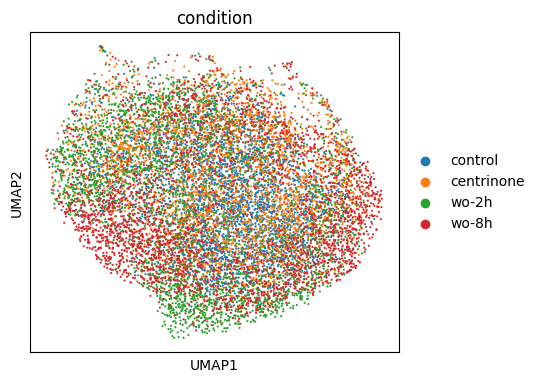

In [8]:
rcParams['figure.figsize'] = (20, 10)
fig_ind = np.arange(231, 237)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)
p12 = sc.pl.umap(A_adata, color='condition', ax=fig.add_subplot(fig_ind[2]), show=False)
plt.show()

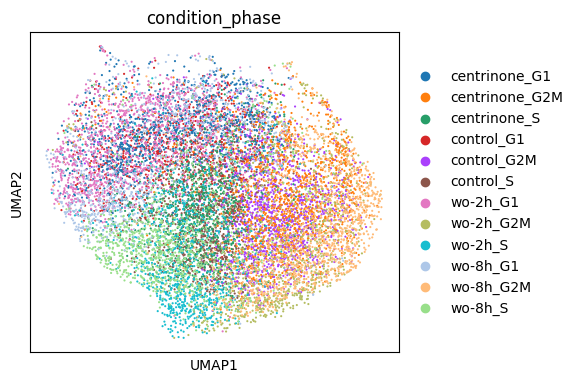

In [9]:
# Plot the UMAP with phase and condition combined
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)
A_adata.obs['condition'] = A_adata.obs['condition'].astype('str')
A_adata.obs['phase'] = A_adata.obs['phase'].astype('str')
A_adata.obs['condition_phase'] = A_adata.obs['condition'] + '_' + A_adata.obs['phase']
p13 = sc.pl.umap(A_adata, color='condition_phase', ax=fig.add_subplot(fig_ind[3]), show=False)
plt.show()

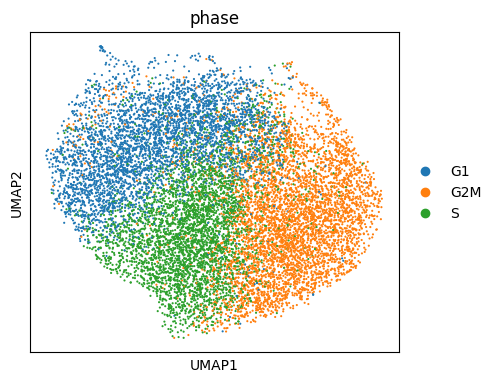

In [10]:
# Plot the UMAP with phase and condition combined
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)
p13 = sc.pl.umap(A_adata, color='phase', ax=fig.add_subplot(fig_ind[3]), show=False)
plt.show()

In [11]:
def calculate_rna_metabolic_percentage(full_adata, rna_metabolic_adata):

    """
    Calculate the percentage of total expression from RNA metabolic pathway genes
    
    Parameters:
    full_adata: AnnData object with all genes (12572 × 11428)
    rna_metabolic_adata: AnnData object with RNA metabolic genes (12572 × 1314)
    """
    
    # Get total counts for RNA metabolic genes per cell
    # Use 'counts' layer for raw counts, or .X if it contains raw counts
    if 'counts' in rna_metabolic_adata.layers:
        rna_metabolic_counts = np.array(rna_metabolic_adata.layers['counts'].sum(axis=1)).flatten()
    else:
        rna_metabolic_counts = np.array(rna_metabolic_adata.X.sum(axis=1)).flatten()
    
    # Get total counts for all genes per cell
    # Use the precomputed total_counts if available, otherwise calculate
    if 'total_counts' in full_adata.obs.columns:
        total_counts = full_adata.obs['total_counts'].values
    else:
        if 'counts' in full_adata.layers:
            total_counts = np.array(full_adata.layers['counts'].sum(axis=1)).flatten()
        else:
            total_counts = np.array(full_adata.X.sum(axis=1)).flatten()
    
    # Calculate percentage
    rna_metabolic_percentage = (rna_metabolic_counts / total_counts) * 100
    
    return rna_metabolic_percentage

def plot_rna_metabolic_violin(adata, percentage_col='rna_metabolic_percentage', palette='Set1'):
    """
    Create violin plot with individual points, colored by cell cycle phase.
    
    Parameters:
    adata: AnnData object with RNA metabolic percentage in .obs
    percentage_col: Column name storing RNA metabolic percentage
    palette: Seaborn color palette for phases
    """
    plt.figure(figsize=(12, 8))
    ax = plt.gca()
    
    # 1. Create violin plot (split by phase)
    sns.violinplot(
        data=adata.obs,
        x='condition',
        y=percentage_col,
        hue='phase',
        inner='quartile',  # Show quartile lines
        palette='dark',
        dodge=True,       # Split violins by phase
        ax=ax,
        legend=True,  # Hide legend for now
    )
    
    # 2. Overlay stripplot with jittered points
    sns.stripplot(
        data=adata.obs,
        x='condition',
        y=percentage_col,
        hue='phase',
        dodge=True,        # Align points with violins
        jitter=0.2,        # Spread points horizontally
        size=2,            # Point size
        palette='gray',  # Use dark palette for points
        linewidth=0.5,
        ax=ax,
        legend=False       # Reuse violin legend
    )
    
    # Enhance plot aesthetics
    plt.title('RNA Metabolic Pathway Expression by Condition and Phase', 
              fontsize=16, pad=20)
    plt.xlabel('Condition', fontsize=14)
    plt.ylabel('Expression (%)', fontsize=14)
    plt.xticks(rotation=0)  # Keep labels horizontal
    plt.grid(axis='y', alpha=0.3)
    
    # Consolidate legends
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[:len(adata.obs['phase'].unique())],  # Unique phases
               labels[:len(adata.obs['phase'].unique())], 
               title='Cell Cycle Phase',
               loc='best')
    
    plt.tight_layout()
    plt.show()

def plot_simple_violin(adata, percentage_col='rna_metabolic_percentage'):
    """
    Simplified violin plot with points (no phase separation).
    """
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    
    # Violin + stripplot combo
    sns.violinplot(
        data=adata.obs,
        x='condition',
        y=percentage_col,
        color='skyblue',  # Uniform color
        inner=None        # Hide inner bars
    )
    sns.stripplot(
        data=adata.obs,
        x='condition',
        y=percentage_col,
        color='black',   # Distinct points
        size=2.5,
        alpha=0.7,       # Semi-transparent
        jitter=0.3
    )
    
    plt.title('RNA Metabolic Expression by Condition', fontsize=15)
    plt.xlabel('Condition', fontsize=12)
    plt.ylabel('Expression (%)', fontsize=12)
    plt.grid(axis='y', alpha=0.2)
    plt.tight_layout()
    plt.show()

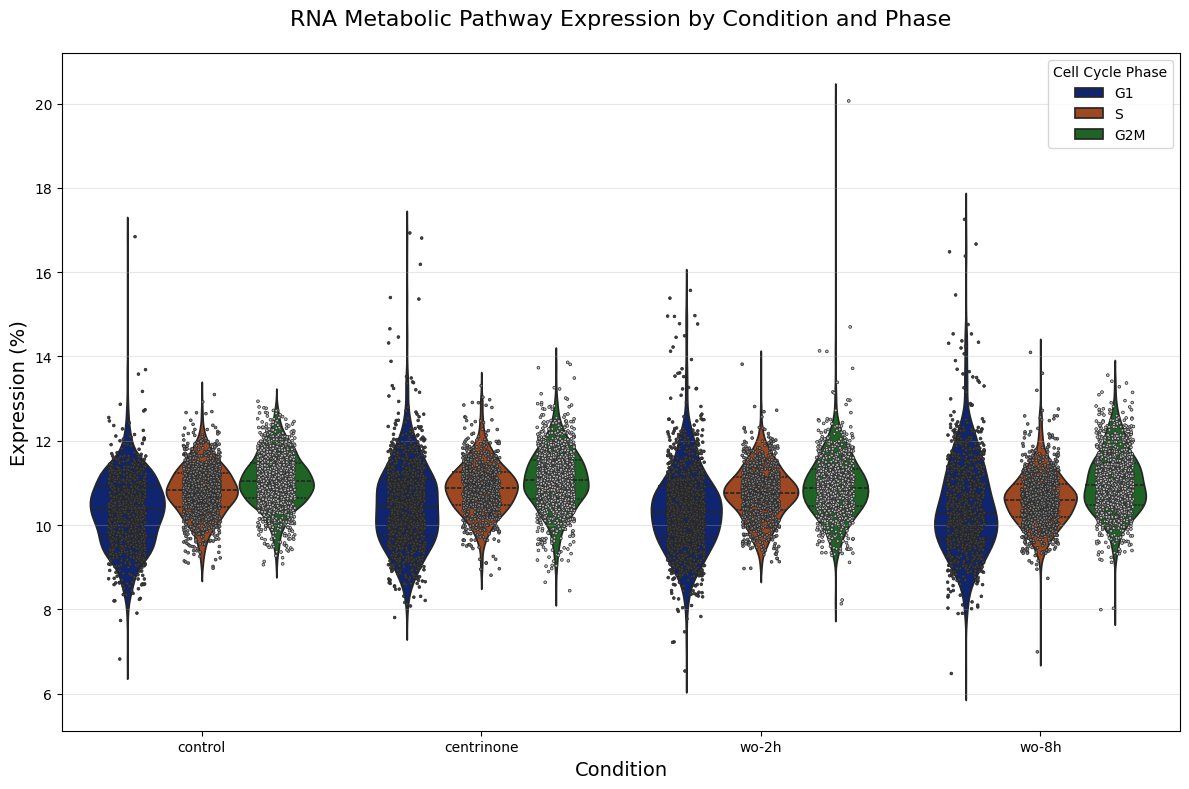

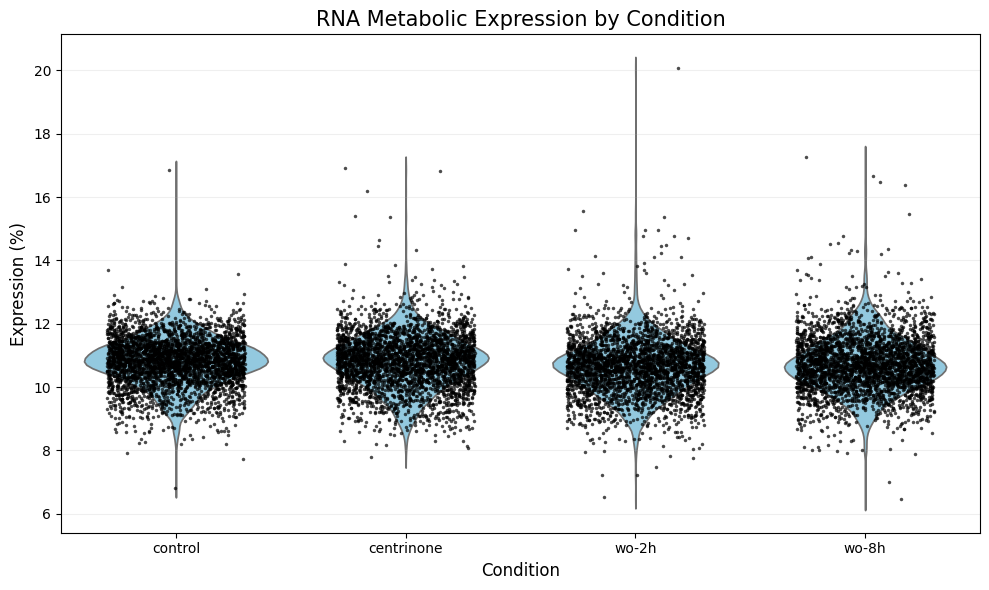

In [12]:
percentage_col = calculate_rna_metabolic_percentage(adata, A_adata)
plot_rna_metabolic_violin(adata, percentage_col= percentage_col)
plot_simple_violin(adata, percentage_col=percentage_col)

In [13]:
# save the anndata object with the new annotations
A_adata.write("/home/jiguo/data/pro_data/adata_all_cc_with_selected_gene_expression.h5")